In [132]:
import gym
import seagul.envs

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
import torch.nn as nn


from itertools import product
from utils.nn_utils import fit_model
from utils.integration_utils import rk4

In [133]:
env = gym.make('lorenz-v0')
env.dt = .01

In [134]:
#Simulate the system from many initial conditions

num_steps = 5000

min_x = 0;     max_x = 0;    n_xtrials = 1
min_y = 1.0;     max_y = 1.0;  n_ytrials = 1
min_z = 1.05;     max_z = 1.05;  n_ztrials = 1

state_hist  = np.zeros((num_steps, n_xtrials*n_ytrials*n_ztrials ,3))
dstate_hist = np.zeros((num_steps, n_xtrials*n_ytrials*n_ztrials ,3))
action = np.array([0,0,0]) # We're going to try and learn the passive dynamics

init_xvals = np.linspace(min_x, max_x, n_xtrials)
init_yvals = np.linspace(min_y, max_y, n_ytrials)
init_zvals = np.linspace(min_z, max_z, n_ztrials)

for trial_n, (init_x,init_y,init_z) in enumerate(product(init_xvals, init_yvals, init_zvals)):
    state = env.reset()
    env.init_state = np.array([init_x, init_y, init_z])
    
    for i in range(num_steps):
        state_hist[i, trial_n, :] = state
        state,reward,done, _ = env.step(action)
        dstate_hist[i,trial_n, :] = ds
        #trail_n += 1


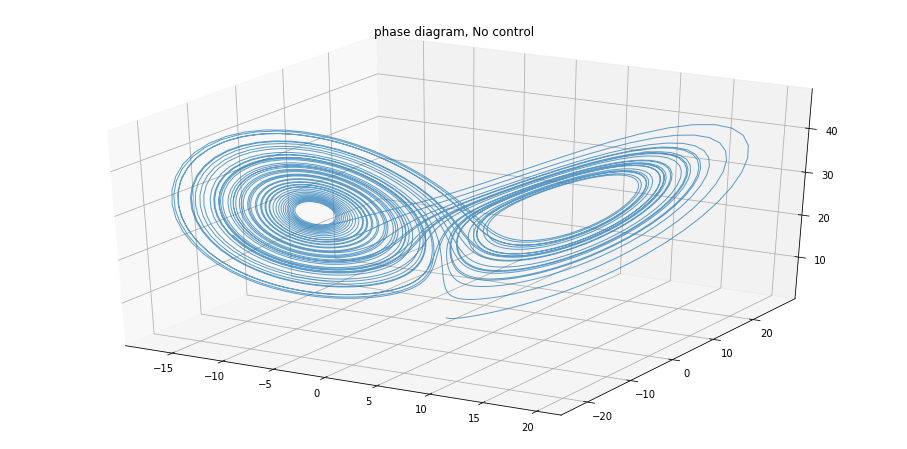

In [135]:
x = state_hist[:,0,0]; y = state_hist[:,0,1]; z = state_hist[:,0,2]

fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')
ax.plot(x,y,z, alpha=0.7, linewidth=1)
ax.set_title('phase diagram, No control')


import scipy.io
scipy.io.savemat('./lorenz.mat', mdict={'state' : state_hist[:,0,:]})


100%|██████████| 200/200 [01:03<00:00,  3.36it/s]


Text(0.5, 1.0, 'loss')

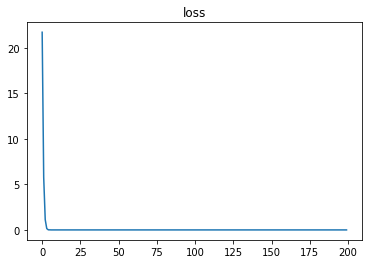

In [138]:
model = nn.Sequential(
    nn.Linear(3,16),
    nn.Tanh(),
    nn.Linear(16,16),
    nn.Tanh(),
    nn.Linear(16,16),
    nn.Tanh(),
    nn.Linear(16,3),
)

loss_hist = fit_model(model, state_hist.reshape(-1,3), dstate_hist.reshape(-1,3), num_epochs=200, learning_rate=1e-2, shuffle=True)
plt.plot(loss_hist)
plt.title('loss')

Text(0.5, 0.92, 'phase diagram, of learned model')

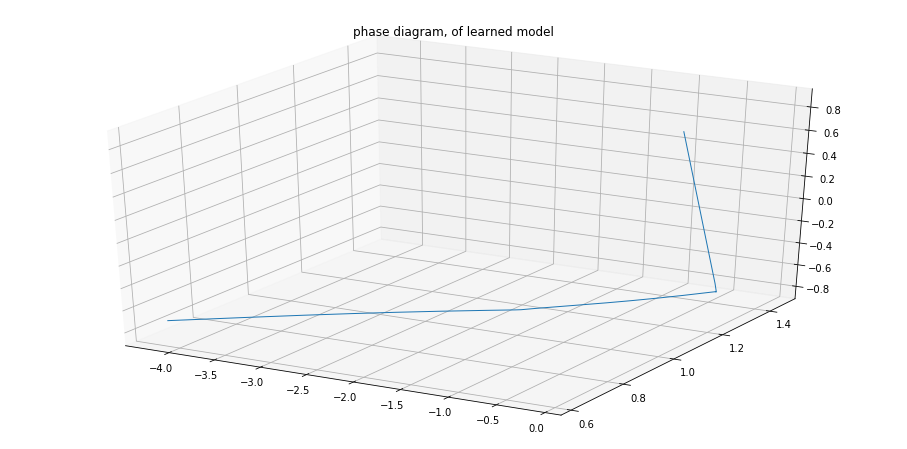

In [141]:
state = np.array([0,1,1.5])
num_steps = 2000

nn_state = np.zeros((num_steps,3))

policy = lambda t,q,a: model(q)

for i in range(num_steps):
    state = rk4(policy, action, 0, .01,  torch.as_tensor(state))
    nn_state[i,:] = state.detach()
    

x = nn_state[:,0]; y = nn_state[:,1]; z = nn_state[:,2]

fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')
ax.plot(x,y,z, alpha=1, linewidth=1)
ax.set_title('phase diagram, of learned model')



Text(0.5, 0.92, 'phase diagram, No control')

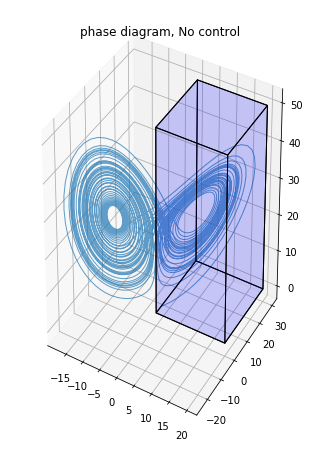

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

def plot_cube(cube_definition):
    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]

    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]

    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]

    #fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    faces = Poly3DCollection(edges, linewidths=1, edgecolors='k')
    faces.set_facecolor((0,0,1,0.1))

    ax.add_collection3d(faces)

    # Plot the points themselves to force the scaling of the axes
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0)

    ax.set_aspect('equal')


cube_definition = [
    (0,0,0), (20,0,0), (0,30,0), (0,0,50)
]

fig = plt.figure(figsize=(16,8))

plot_cube(cube_definition)

x = state_hist[:,0,0]; y = state_hist[:,0,1]; z = state_hist[:,0,2]

ax = fig.gca(projection='3d')
ax.plot(x,y,z, alpha=0.7, linewidth=1)
ax.set_title('phase diagram, No control')

